# Bias in the profile Poisson likelihood

> You can find an interactive version of this Jupyter notebook in my [github](https://github.com/giacomov/giacomov.github.io/tree/master/notebooks)

A common method used when modeling spectra in the X-rays and gamma-rays community involves the maximization of a profile likelihood commonly called CSTAT. 

## CSTAT derivation

We start from an observed spectrum accumulated in a source region (a time interval with a signal for a time series or a circular region containing a source for a 2d dataset), and a background spectrum obtained by counting events in a "background region", usually an off-source interval for 1-d data or a control region like an annulus around the source of interest in 2-d data. Let's assume both spectra have the same number of bins $N$.

Following the same notation as in the [XSpec manual](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/XSappendixStatistics.html), let's consider the i-th bin in the spectra, with these definitions:

* $t_s$ is the exposure for the on-source spectrum
* $t_b$ is the exposure for the background spectrum
* $S_i$, $B_i$ are the number of counts respectively in the on-source and in the off-source spectrum
* $m_i$ is the expected *rate* of events from the source model under consideration (i.e., a spectral model convolved with the response of the instrument)
* $b_i$ is the expected *rate* of events from the background model under consideration

Both the source and background counts are Poisson random variables. Let's derive the formula for CSTAT using the [sympy](http://www.sympy.org/en/index.html) package for symbolic computation:

In [2]:
from sympy import *
from IPython.display import display
init_printing()

# define symbols
ts,mi,bi,Si,tb,bi,Bi = symbols("t_s m_i b_i S_i t_b b_i B_i", 
                               real=True, 
                               nonnegative=True)

The expected number of counts from the source model is $t_s (m_i + b_i)$, so the Poisson distribution for the source spectrum is:

In [3]:
# Source Poisson distribution
P1 = (ts*(mi+bi))**Si * exp(-(ts*(mi+bi))) / factorial(Si)

display(P1)

The expected number of counts for the background is $t_b b_i$:

In [4]:
P2 = (tb * bi)**Bi * exp(-(tb*bi)) / factorial(Bi)

display(P2)

The joint probability of observing $S_i$ counts in the source spectrum and $B_i$ counts in the background spectrum is $P1 \times P2$. Let's then take the logarithm of it, which is our [log(likelihood)](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood) function:

In [5]:
P = P1 * P2

L = log(P).expand().simplify()

display(L)

And here is the important bit: we now assume we do not have any information on the background model, so we consider each expectation in the background spectrum $b_i$ as a parameter free to vary. In other words, we use a background model with $N$ parameters (as many as the number of bins in the spectra) all free to vary independently of each other. This is the [maximum variance model](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). We can then consider the [profile likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Profile_likelihood) obtained by profiling out (i..e, maximizing the likelihood with respect to) the $b_i$. In order to do so, we take the partial derivative with respect to the $b_i$ and solve the equation $\delta L / \delta b_i = 0$ (because at the maximum of L all partial derivatives must be zero):

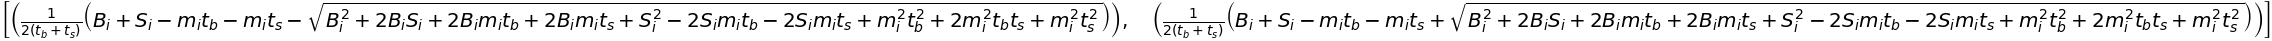

In [6]:
dLdb = diff(L, bi)

res = solve([dLdb], [bi])

display(res)

Of the two solutions, we take the second one which is positive (the expected background cannot be negative):

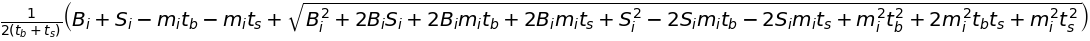

In [7]:
bi_mle = res[1][0]

bi_mle.factor().simplify()

We can now substitute it into the equation of the log likelihood. However, it becomes a very long expression:

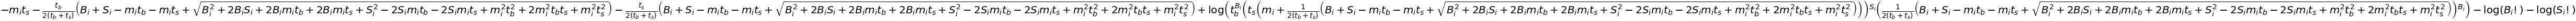

In [8]:
L.subs(bi, bi_mle)

Instead, we will simply compute the numerical value for $b_i$ first and then plug that into the log likelihood.

> All the code used in the following is implemented in the last cell of this notebook. Execute that first if you are running the notebook interactively.

## Bias in CSTAT

Let's now test the formula.

In order to avoid unnecessary complications, we consider a very simple case where we have a source with a constant spectrum and a background that is constant as well. We also assume an exposure of 1 second for both the source and the background spectrum and an ideal instrument (no need to convolve by the effective area). This allows us to focus on the problem at hand, instead of the details of an X-ray or gamma-ray analysis.

In a real situation we do not know the true models. We will assume a constant for the source, and we will use the CSTAT trick for the background (i.e., a stepwise model with $N$ parameters free to vary independently).

Let's simulate a dataset and fit it using CSTAT. This is achieved with my `fit_one_realization` function:

Reconstructed value: 32.35


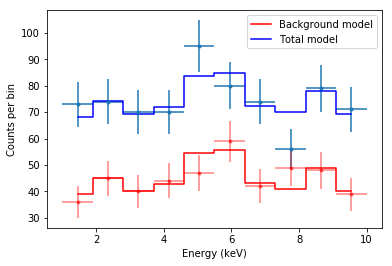

In [9]:
source_rate = 30.0
background_rate = 50.0
number_of_bins = 10
# This is to guarantee repeatibility
random_seed = 0

res = fit_one_realization(random_seed, number_of_bins, 
                          source_rate, background_rate, 
                          plot=True)
print("Reconstructed value: %.2f" % res)

The method worked. Now, let's observe carefully the plot and understand exactly what is happening.

The red data points are the counts in the background spectrum, and the red model is the maximum variance model used by CSTAT, where every $b_i$ is given by the solution we called `bi_mle` above. As you can see, even though the true model is a constant, the background model jumps up and down quite a lot. This is the effect of considering as many parameters as there are bins. 

The total model is given by the source model (a constant) plus the background model. This is why the total model is not a flat line anymore.

Now let's consider the point around 5 keV. There is an upward fluctuation in the total model (remember that the true model is actually a constant at 30 + 50 = 80 counts per keV). Thus, in the background model, the parameter $b_i$ for that particular bin is pulled upward. At the opposite, around 7.5 keV there is a underflucutation in the total model, and the background model is pulled downward.  

The problems start showing up when the number of bins in the spectra increases so that many of them are either 0 or 1. I will show this by performing many simulations (16000) of the same situation (source rate = 30 counts/keV, background rate = 50 counts/keV) but varying the number of bins in the spectrum:

16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed


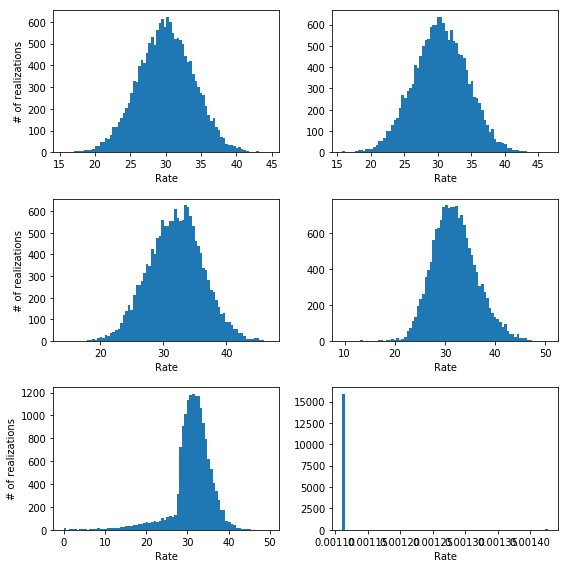

In [10]:
# Let's make a bunch of simulations

source_rate = 30.0
background_rate = 50.0

number_of_bins = [50, 100, 200, 400, 500, 1600]
n_realizations = 16000

fig, subs = plt.subplots(3,2, figsize=(8, 8))

for i, (sub, n_bins) in enumerate(zip(subs.flatten(), 
                                      number_of_bins)):

    # No rebinning
    res = fit_many_realizations(n_realizations, n_bins, 
                                source_rate, 
                                background_rate, 
                                fit_one_realization,
                                rebin=0.0)
        
    _ = sub.hist(res, 80)
        
    sub.set_xlabel("Rate")
    
    if (i+1) % 2 != 0:
        
        sub.set_ylabel("# of realizations")

fig.tight_layout()

We can clearly see that while in the first two cases in the upper panels the method returns an estimate for the rate that is centered on the true value (30), for the case in the second rows there is a clear bias towards larger rates. Moreover, when the number of bins increases even more (third row) we have a bias and a lot of very wrong results (look at the left tail of the distribution on the left) until we get to the point where all fits return an estimated rate of zero (lower right panel).

This problem have to do with two things: the number of parameters in the background model for the last two cases is really large compared to the information contained in the data. Essentially we are modeling a constant with 500 and 1600 independent parameters! 

Moreover, when the counts in the background $B_i$ are zero, then $b_i$ is zero. Indeed we have:

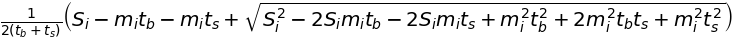

In [11]:
bi_mle.subs(Bi, 0).simplify()

Even though sympy is not smart enough to recognize it, the expression in the square root is actually equal to $(m_i t_b + m_i t_s - S_i)^2$:

In [12]:
((mi * tb + mi * ts - Si)**2).expand()

so if $B_{i}=0$ then $b_i=0$ independently of $m_i$ and $S_i$. This is unphysical (the background cannot be zero, and also violates the assumptions we started from because the rate parameter of a Poisson distribution cannot be zero). Essentially, there is little to no information about the background when this happens and the formulation of the problem breaks down. As we have just seen, this introduces a bias which becomes more and more severe as the number of bins where this happens increase.

If this is the case, then a simple countermeasure is to rebin the spectra so that there is at least some background counts in each bin. Let's see if this solves the problem:

16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed


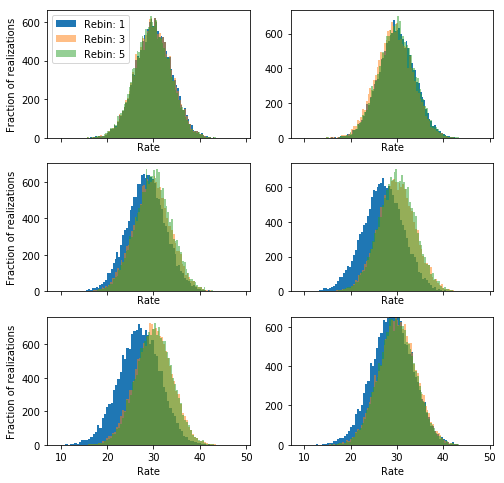

In [13]:
fig, subs = plt.subplots(3,2, figsize=(8, 8), sharex=True)

for i, (sub, n_bins) in enumerate(zip(subs.flatten(), 
                                      number_of_bins)):
    
    # min counts in background = 1
    res1 = fit_many_realizations(n_realizations, n_bins, 
                                 source_rate, 
                                 background_rate, 
                                 fit_one_realization,
                                 rebin=1.0)
    
    res3 = fit_many_realizations(n_realizations, n_bins, 
                                 source_rate, 
                                 background_rate, 
                                 fit_one_realization,
                                 rebin=3.0)
    
    res5 = fit_many_realizations(n_realizations, n_bins, 
                                 source_rate, 
                                 background_rate, 
                                 fit_one_realization,
                                 rebin=5.0)
        
    _ = sub.hist(res1, 80, label='Rebin: 1')
    _ = sub.hist(res3, 80, label='Rebin: 3', alpha=0.5)
    _ = sub.hist(res5, 80, label='Rebin: 5', alpha=0.5)
        
    sub.set_xlabel("Rate")
    
    if (i+1) % 2 != 0:
        
        sub.set_ylabel("Fraction of realizations")

#_ = subs[-1][-1].set_xlim([10, 50])
_ = subs[-1][-1].set_ylim([0, 650])

_ = subs[0][0].legend(loc=0)

It looks like rebinning with 1 counts correct in large part but not completely the problem, but using 3 or 5 is much better.

> NOTE: here we are dealing with a simple illustrative problem. In a real situation, you should be a little conservative with the number of counts you require for each bin in the background.

# An alternative: model the background directly

An even better solution to the problem is to avoid the use of the profile likelihood alltogether, and instead model simultaneously the background and the data with two explicit models (one for the source, one for the background).

We can then use the normal Poisson log-likelihood (aka Cash statistic) for both separately and then sum them and maximize the sum varying the parameters of both the source and the background model.

This has many advantages beyond solving the problem with the bias outlined above:

1. We use a much better trade off between variance and bias in the background
2. When computing errors on parameters we can take into account the covariance between parameters in the background and in the source model
3. The background model is explicit and can be tested

For the simple example treated here, this is very straightforward. I coded this in the `fit_one_realization_no_profiling` function, let's see how it behaves:

16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed
16000 of 16000 completed


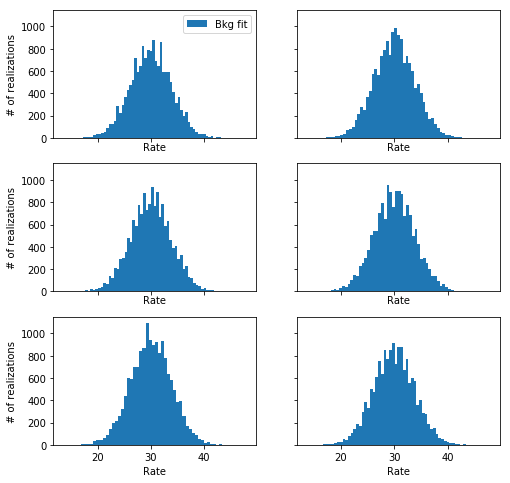

In [15]:
fig, subs = plt.subplots(3,2, figsize=(8, 8), sharex=True, sharey=True)

for i, (sub, n_bins) in enumerate(zip(subs.flatten(), 
                                      number_of_bins)):
    
    # Fit
    resf = fit_many_realizations(n_realizations, n_bins, 
                                 source_rate, 
                                 background_rate, 
                                 fit_one_realization_no_profiling,
                                 rebin=0.0)
    
    _ = sub.hist(resf, 60, label='Bkg fit')

        
    sub.set_xlabel("Rate")
    
    if (i+1) % 2 != 0:
        
        sub.set_ylabel("# of realizations")

_ = subs[0][0].legend(loc=0)

# Code

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import multiprocessing
import functools
import sys
%matplotlib inline
from numba import jit


def generate_data(n_bins, src_rate, bkg_rate):
    start = 1.0  # keV
    stop = 10.0  # keV

    dE = (stop - start) / n_bins

    edges = np.linspace(start, stop, n_bins + 1)

    energy_centers = (edges[1:] + edges[:-1]) / 2.0

    observation = np.random.poisson((src_rate + bkg_rate) * dE, n_bins).astype(float)

    background = np.random.poisson(bkg_rate * dE, n_bins).astype(float)

    return energy_centers, dE, observation, background


# This is a translation in python of the method
# StdCstat::specificPerformB in CstatVariants.cxx
# from the XSpec source code
@jit(nopython=True)
def cstat_xspec(S, B, expos_ratio, y, rebin=0.0):

    assert len(S) == len(B)
    assert len(y) == len(S)

    if rebin > 0.0:

        newS = np.zeros_like(S)
        newB = np.zeros_like(B)
        newy = np.zeros_like(y)

        m = 0
        j = 0
        k = 0

        for i, bi in enumerate(B):

            m += bi

            if i == len(B) - 1:

                if m >= rebin:

                    newS[k] = np.sum(S[j: i + 1])
                    newB[k] = np.sum(B[j: i + 1])
                    newy[k] = np.sum(y[j: i + 1])

                    k += 1

                else:

                    # We reached the end but we don't have
                    # enough counts in the last bin. Let's
                    # incorporate these in the last bin
                    # of the rebinned one
                    newS[k - 1] += np.sum(S[j:])
                    newB[k - 1] += np.sum(B[j:])
                    newy[k - 1] += np.sum(y[j:])

                break

            if m >= rebin:
                newS[k] = np.sum(S[j: i + 1])
                newB[k] = np.sum(B[j: i + 1])
                newy[k] = np.sum(y[j: i + 1])

                m = 0
                j = i + 1
                k += 1

        assert np.sum(S) == np.sum(newS[:k]), "Sum of S is different"
        assert np.sum(B) == np.sum(newB[:k]), "Sum of B is different"
        assert abs(np.sum(newy[:k]) - np.sum(y)) < 0.01, "Sum of y is different"

        S = newS[:k]
        B = newB[:k]
        y = newy[:k]

        assert np.all(B >= rebin)

    tsi = 1.0
    tbi = 1.0

    FLOOR = 1.0e-5
    stat = 0

    F = np.zeros_like(S)

    #   for (size_t i=0; i<N; i++) {
    for i in range(len(S)):
        #       Real si = sbin[i];
        si = S[i]
        #       Real bi = bbin[i];
        bi = B[i]

        # NOTE: for simplicity tsi and tbi are 1 for all bins
        #       Real tsi = tsbin[i];
        #       Real tbi = tbbin[i];
        # tsi = ts[i]
        # tbi = tb[i]

        #       Real yi = ybin[i];
        yi = y[i]

        #       Real ti = tsi + tbi;
        ti = tsi + tbi

        #       yi = std::max(yi, FLOOR/tsi);
        yi = max(yi, FLOOR / tsi)

        #     if (si == 0.0) {
        if si == 0.0:

            stat += tsi * yi - bi * np.log(tbi / ti)
        #       } else {
        else:
            #           if (bi == 0.0) {
            if bi == 0.0:
                # 	  stat += tsi*yi + si*(std::log(si)-std::log(tsi*yi)-1);
                # 	}
                #               if ( yi <= si/ti ) {
                if yi <= si / ti:
                    #                   stat += -tbi*yi - si*std::log(tsi/ti);
                    stat += -tbi * yi - si * np.log(tsi / ti)
                #               } else {
                else:
                    #                   stat += tsi*yi + si*(std::log(si)-std::log(tsi*yi)-1);
                    stat += tsi * yi + si * (np.log(si) - np.log(tsi * yi) - 1)
            else:

                #               // now the main case where both data and background !=0
                #               // Solve quadratic equation for f. Use the positive root to ensure
                #               // that f > 0.
                #               Real a = ti;
                a = ti
                #               Real b = ti*yi - si - bi;
                b = ti * yi - si - bi
                #               Real c = -bi*yi;
                c = -bi * yi
                #               Real d = sqrt(b*b - 4.0*a*c);
                d = np.sqrt(b * b - 4.0 * a * c)
                #               if ( b >= 0.0 ) {
                if b >= 0:
                    #                   f = -2*c / (b + d);
                    f = -2 * c / (b + d)
                #               } else {
                else:
                    #                   f = -(b - d) / (2*a);
                    f = -(b - d) / (2 * a)
                # This is to keep track of the profiled out background parameter
                F[i] = f

                #               stat += tsi*yi + ti*f - si*std::log(tsi*yi+tsi*f)
                #                       - bi*std::log(tbi*f) - si*(1-std::log(si))
                #                       - bi*(1-std::log(bi));
                stat += tsi * yi + ti * f - si * np.log(tsi * yi + tsi * f) \
                        - bi * np.log(tbi * f) - si * (1 - np.log(si)) \
                        - bi * (1 - np.log(bi))

    return stat, F


# Wrapper than can be used in scipy.minimize
def cstat_wrapper(rate, obs, bkg, dE, rebin, full=False, cstat_function=cstat_xspec):
    # Only one parameter, the rate

    # Compute expected model counts
    model_counts = np.repeat(rate * dE, obs.shape[0])

    if full:

        return cstat_function(obs, bkg, 1.0,
                              model_counts, rebin)

    else:

        return cstat_function(obs, bkg, 1.0,
                              model_counts, rebin)[0]


def fit(obs, bkg, dE, x0, rebin=0.0):

    results = scipy.optimize.minimize_scalar(cstat_wrapper, bounds=(0.0, x0 * 10.0),
                                             args=(obs, bkg, dE, rebin),
                                             method='Bounded')

    if not results.success:
        raise RuntimeError("Fit failed with reason %s" % results.message)

    return results.x


def fit_one_realization(seed,
                        n_bins,
                        true_src_rate,
                        true_bkg_rate,
                        plot=False,
                        rebin=0.0):

    np.random.seed(seed)

    energies, dE, obs, bkg = generate_data(n_bins,
                                           true_src_rate,
                                           true_bkg_rate)

    # print(np.average(obs - bkg) / dE)

    # We start the fit from very close to the true value so that if the fit
    # converges somewhere else it is something intrinsic to the
    # likelihood function, and not a minimization problem
    mle_est = fit(obs, bkg, dE, true_src_rate, rebin=rebin)

    if plot:

        # Get the values for the nuisance parameters
        _, bkg_nuisance = cstat_wrapper(mle_est, obs, bkg, dE,
                                        rebin=rebin,
                                        full=True)

        _ = plt.errorbar(energies, obs, xerr=dE / 2.0,
                         yerr=np.sqrt(obs), fmt='.')

        _ = plt.errorbar(energies, bkg, xerr=dE / 2.0,
                         yerr=np.sqrt(bkg),
                         color='red', alpha=0.5, fmt='.')

        if rebin == 0:
            
            _ = plt.step(energies, bkg_nuisance,
                         color='red', where='mid',
                         label='Background model')

            _ = plt.step(energies,
                         mle_est * dE + bkg_nuisance,
                         color='blue', where='mid',
                         label='Total model')
            
            _ = plt.legend(loc=0)

        _ = plt.xlabel("Energy (keV)")
        _ = plt.ylabel("Counts per bin")
        

    return mle_est


# Wrapper than can be used in scipy.minimize
# This implements the cstat when the background model is
# a constant (no profiling)
def cstat_no_profiling(parameters, obs, bkg, dE, rebin=None, full=False):
    src_rate, bkg_rate = parameters

    # Assume exposure=1 for simplicity
    exposure = 1.0

    # Compute expected model counts
    src_model_counts = np.repeat((src_rate + bkg_rate) * dE * exposure, obs.shape[0])
    bkg_model_counts = np.repeat(bkg_rate * dE * exposure, obs.shape[0])

    cstat_src = -np.sum(obs * np.log(src_model_counts) - src_model_counts)
    cstat_bkg = -np.sum(bkg * np.log(bkg_model_counts) - bkg_model_counts)

    cstat = cstat_src + cstat_bkg

    if full:

        return cstat, bkg_model_counts

    else:

        return cstat


def fit_no_profiling(obs, bkg, dE, x0):
    results = scipy.optimize.minimize(cstat_no_profiling, x0,
                                      args=(obs, bkg, dE),
                                      tol=1e-3)

    if not results.success:
        raise RuntimeError("Fit failed with reason %s" % results.message)

    return results.x


def fit_one_realization_no_profiling(seed,
                                     n_bins,
                                     true_src_rate,
                                     true_bkg_rate,
                                     plot=False,
                                     rebin=None):
    np.random.seed(seed)

    energies, dE, obs, bkg = generate_data(n_bins,
                                           true_src_rate,
                                           true_bkg_rate)

    # print(np.average(obs - bkg) / dE)

    # We start the fit from very close to the true value so that if the fit
    # converges somewhere else it is something intrinsic to the
    # likelihood function, and not a minimization problem
    mle_est = fit_no_profiling(obs, bkg, dE, [true_src_rate,
                                              true_bkg_rate])

    exposure = 1.0

    if plot:
        _ = plt.errorbar(energies, obs, xerr=dE / 2.0,
                         yerr=np.sqrt(obs), fmt='.')

        _ = plt.axhline((mle_est[0] + mle_est[1]) * dE * exposure,
                        color='blue',
                        label='Total model')

        _ = plt.errorbar(energies, bkg, xerr=dE / 2.0,
                         yerr=np.sqrt(bkg),
                         color='red', alpha=0.5, fmt='.')

        _ = plt.axhline(mle_est[1] * dE * exposure,
                        color='red',
                        label='Background model')

        _ = plt.xlabel("Energy (keV)")
        _ = plt.ylabel("Counts per bin")
        _ = plt.legend(loc=0)

    return mle_est[0]


def fit_many_realizations(n_realizations,
                          n_bins,
                          true_src_rate,
                          true_bkg_rate,
                          fit_function=fit_one_realization,
                          rebin=None,
                          parallel=True):

    mle_estimates = np.empty(n_realizations)

    worker = functools.partial(fit_function,
                               n_bins=n_bins,
                               true_src_rate=true_src_rate,
                               true_bkg_rate=true_bkg_rate,
                               plot=False,
                               rebin=rebin)
    if parallel:

        pool = multiprocessing.Pool()

        try:

            for i, res in enumerate(pool.imap(worker,
                                              range(n_realizations),
                                              chunksize=1000)):
                mle_estimates[i] = res

                sys.stderr.write("\r%i of %i completed" % (i + 1, n_realizations))

        except:

            raise

        finally:

            pool.close()
            pool.join()

        sys.stderr.write("\n")

    else:

        # This is for testing purposes, avoiding the parallel execution

        mle_estimates = map(worker, range(n_realizations))

    return mle_estimates
